## This file makes some further categories

In [ ]:
params_file = None
input_file = None
output_file = None

In [6]:
import pandas as pd
import numpy as np
import re
pd.options.mode.chained_assignment = None

In [ ]:
import json
with open(params_file) as f:
    data = json.load(f)
min_count = int(data['nuanced_categories']['min_count_species'])
min_scalar = float(data['nuanced_categories']['min_scalar'])
min_prop = float(data['nuanced_categories']['min_prop'])
prefix = data['nuanced_categories']['prefix']

In [ ]:
meta = pd.read_csv(input_file)
meta['primefolder'] = meta['filename'].apply(lambda x: x.split('/')[0])
meta['oggname'] = meta['filename'].apply(lambda x: x.split('/')[1])
meta['audio'] = meta['filename'].apply(lambda x: 'train_audio/' + x)

## Calculate the time of day variable

<Axes: title={'center': 'Time of Day'}, xlabel='Time of Day', ylabel='Count'>

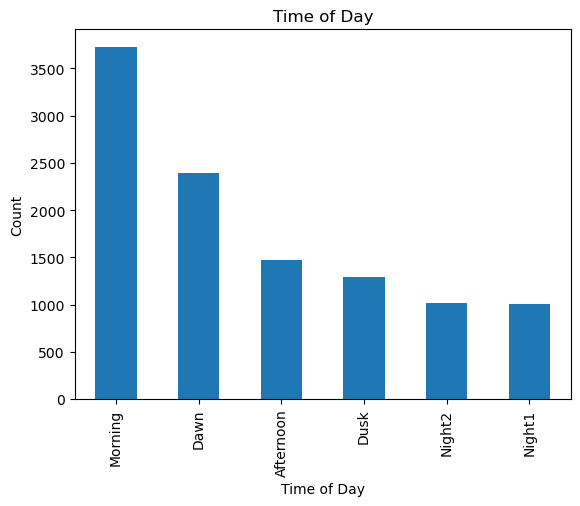

In [102]:
# Calculate the time of day
bins = [0, 4, 8, 12, 16, 20, 24]  # Define the bin edges
labels = ['Night2', 'Dawn', 'Morning', 'Afternoon', 'Dusk', 'Night1']  # Define the labels for the bins
meta['time_of_day'] = pd.cut(meta['hour_int'] % 24, bins=bins, labels=labels, right=False)
# meta[['hour_int', 'time_of_day']].head()
meta['time_of_day'].value_counts().plot(kind='bar', title='Time of Day', xlabel='Time of Day', ylabel='Count')

## Gather data about sex, life stage, types of calls, and time of day

In [103]:

# process the type column
meta['type_list'] = meta['type'].apply(lambda x: x.strip('[]\'').split(', ')).tolist()
meta['type_list'] = meta['type_list'].apply(lambda x: [_.strip('\'') for _ in x])
meta['type_list'] = meta['type_list'].apply(lambda x: [item.lower() for item in x])
meta['type_list'] = meta['type_list'].apply(lambda x: [item.replace(' ','') for item in x])

# gather nlp information
meta['flightcall'] = meta['type_list'].apply(lambda x: 1 if 'flightcall' in x else 0)
meta['call'] = meta['type_list'].apply(lambda x: 1 if 'call' in x else 0)
meta['song'] = meta['type_list'].apply(lambda x: 1 if 'song' in x else 0)
meta['nocturnalflightcall'] = meta['type_list'].apply(lambda x: 1 if 'nocturnalflightcall' in x else 0)
meta['alarmcall'] = meta['type_list'].apply(lambda x: 1 if 'alarmcall' in x else 0)
meta['beggingcall'] = meta['type_list'].apply(lambda x: 1 if 'beggingcall' in x else 0)
meta['male'] = meta['type_list'].apply(lambda x: 1 if 'male' in x else 0)
meta['female'] = meta['type_list'].apply(lambda x: 1 if 'female' in x else 0)
meta['sexuncertain'] = meta['type_list'].apply(lambda x: 1 if 'sexuncertain' in x else 0)
meta['adult'] = meta['type_list'].apply(lambda x: 1 if 'adult' in x else 0)
meta['juvenile'] = meta['type_list'].apply(lambda x: 1 if 'juvenile' in x else 0)
meta['lifestageuncertain'] = meta['type_list'].apply(lambda x: 1 if 'lifestageuncertain' in x else 0)

# combine some nlp info with regular expressions
meta['flight_any'] = meta['type_list'].apply(lambda x: 1 if any(re.search(r'flight', item) for item in x) else 0)
meta['song_any'] = meta['type_list'].apply(lambda x: 1 if any(re.search(r'song', item) for item in x) else 0)
meta['nocturnal_any'] = meta['type_list'].apply(lambda x: 1 if any(re.search(r'nocturnal', item) for item in x) else 0)
meta['alarm_any'] = meta['type_list'].apply(lambda x: 1 if any(re.search(r'alarm', item) for item in x) else 0)
meta['wing_any'] = meta['type_list'].apply(lambda x: 1 if any(re.search(r'wing', item) for item in x) else 0)
meta['begging_any'] = meta['type_list'].apply(lambda x: 1 if any(re.search(r'begging', item) for item in x) else 0)

## Augment labels with sex, life stage, types of calls, and time of day

In [104]:
# augment the labels

def augment_sex(row):
    if row['male']:
        return row['primary_label'] + '_male'
    elif row['female']:
        return row['primary_label'] + '_female'
    elif row['sexuncertain']:
        return row['primary_label'] + '_other'
    else:
        return row['primary_label'] + '_other'
    
def augment_lifestage(row):
    if row['adult']:
        return row['primary_label'] + '_adult'
    elif row['juvenile']:
        return row['primary_label'] + '_juvenile'
    elif row['lifestageuncertain']:
        return row['primary_label'] + '_other'
    else:
        return row['primary_label'] + '_other'
    
def augment_activity(row):
    if row['song_any']:
        return row['primary_label'] + '_song'
    elif row['flight_any']:
        return row['primary_label'] + '_flight'
    elif row['alarm_any']:
        return row['primary_label'] + '_alarm'
    elif row['begging_any']:
        return row['primary_label'] + '_begging'
    elif row['wing_any']:
        return row['primary_label'] + '_wing'
    elif row['call']:
        return row['primary_label'] + '_call'
    else:
        return row['primary_label'] + '_other'
    
def augment_time(row):
    if row['time_of_day'] == 'Night1':
        return row['primary_label'] + '_night'
    elif row['time_of_day'] == 'Night2':
        return row['primary_label'] + '_night'
    elif row['time_of_day'] == 'Dawn':
        return row['primary_label'] + '_dawn'
    elif row['time_of_day'] == 'Dusk':
        return row['primary_label'] + '_dusk'
    elif row['time_of_day'] == 'Morning':
        return row['primary_label'] + '_morning'
    elif row['time_of_day'] == 'Afternoon':
        return row['primary_label'] + '_afternoon'
    else:
        # This should not happen
        # Because I filtered on time of day
        return row['primary_label'] + '_unknown'

In [105]:
meta['primary_label_time'] = meta.apply(augment_time, axis=1)
meta['primary_label_activity'] = meta.apply(augment_activity, axis=1)
meta['primary_label_sex'] = meta.apply(augment_sex, axis=1)
meta['primary_label_lifestage'] = meta.apply(augment_lifestage, axis=1)

In [ ]:
# This should already be the case
meta.sort_values(by=['primary_label'], inplace=True)
animals = meta['primary_label'].unique()

# Modify the labels based on the minimum count
# Cannot create a subcategory if the count is less than min_count
feature = 'sex'
labels = []
for animal in animals:
    sub = meta[meta['primary_label'] == animal]
    vc_ct = sub['primary_label_' + feature].value_counts()
    vc_idx = sub['primary_label_' + feature].value_counts().index.tolist()
    pr = sum(vc_ct[vc_ct > min_count]) / sub.shape[0]
    if pr >= min_prop and sum(vc_ct) > min_count * min_scalar:
        labels += sub['primary_label_' + feature].to_list()
    else:
        labels += [animal for _ in range(sub.shape[0])]
meta['primary_label_sex_v2'] = labels

# Modify the labels based on the minimum count
# Cannot create a subcategory if the count is less than min_count
feature = 'time'
labels = []
for animal in animals:
    sub = meta[meta['primary_label'] == animal]
    vc_ct = sub['primary_label_' + feature].value_counts()
    vc_idx = sub['primary_label_' + feature].value_counts().index.tolist()
    pr = sum(vc_ct[vc_ct > min_count]) / sub.shape[0]
    if pr >= min_prop and sum(vc_ct) > min_count * min_scalar:
        labels += sub['primary_label_' + feature].to_list()
    else:
        labels += [animal for _ in range(sub.shape[0])]
meta['primary_label_time_v2'] = labels

# Modify the labels based on the minimum count
# Cannot create a subcategory if the count is less than min_count
feature = 'activity'
labels = []
for animal in animals:
    sub = meta[meta['primary_label'] == animal]
    vc_ct = sub['primary_label_' + feature].value_counts()
    vc_idx = sub['primary_label_' + feature].value_counts().index.tolist()
    pr = sum(vc_ct[vc_ct > min_count]) / len(vc_ct)
    pr = sum(vc_ct[vc_ct > min_count]) / sub.shape[0]
    if pr >= min_prop and sum(vc_ct) > min_count * min_scalar:
        labels += sub['primary_label_' + feature].to_list()
    else:
        labels += [animal for _ in range(sub.shape[0])]
meta['primary_label_activity_v2'] = labels

# Modify the labels based on the minimum count
# Cannot create a subcategory if the count is less than min_count
feature = 'lifestage'
labels = []
for animal in animals:
    sub = meta[meta['primary_label'] == animal]
    vc_ct = sub['primary_label_' + feature].value_counts()
    vc_idx = sub['primary_label_' + feature].value_counts().index.tolist()
    pr = sum(vc_ct[vc_ct > min_count]) / sub.shape[0]
    if pr >= min_prop and sum(vc_ct) > min_count * min_scalar:
        labels += sub['primary_label_' + feature].to_list()
    else:
        labels += [animal for _ in range(sub.shape[0])]
meta['primary_label_lifestage_v2'] = labels



## Report some summary statistics

In [123]:
print('Number of unique labels:')
print('---------------------')
print('Primary, Activity, Sex, Time, Lifestage')
print((len(meta['primary_label'].unique()),
    len(meta['primary_label_activity_v2'].unique()),
    len(meta['primary_label_sex_v2'].unique()),
    len(meta['primary_label_time_v2'].unique()),
    len(meta['primary_label_lifestage_v2'].unique()),
 ))
print()


Number of unique labels:
---------------------
Primary, Activity, Sex, Time, Lifestage
(150, 344, 232, 281, 246)



In [119]:
labels = meta['primary_label_activity_v2'].value_counts().index
counts = meta['primary_label_activity_v2'].value_counts().values
labels_primary = meta['primary_label'].value_counts().index
counts_primary = meta['primary_label'].value_counts().values
print('Activity')
print('-------------------')
print('Number of unique labels:')
print('All augmented labels, Lots of augmented labels, Lots of primary labels')
print(len(labels), len(labels[counts > min_count]), len(labels_primary.unique()), len(labels_primary[counts_primary > min_count]))
print()


Activity
-------------------
Number of unique labels:
All augmented labels, Lots of augmented labels, Lots of primary labels
344 146 150 93



In [120]:
labels = meta['primary_label_sex_v2'].value_counts().index
counts = meta['primary_label_sex_v2'].value_counts().values
labels_primary = meta['primary_label'].value_counts().index
counts_primary = meta['primary_label'].value_counts().values
print('Sex')
print('-------------------')
print('Number of unique labels:')
print('All augmented labels, Lots of augmented labels, Lots of primary labels')
print(len(labels), len(labels[counts > min_count]), len(labels_primary.unique()), len(labels_primary[counts_primary > min_count]))
print()

Sex
-------------------
Number of unique labels:
All augmented labels, Lots of augmented labels, Lots of primary labels
232 111 150 93



In [121]:
labels = meta['primary_label_lifestage_v2'].value_counts().index
counts = meta['primary_label_lifestage_v2'].value_counts().values
labels_primary = meta['primary_label'].value_counts().index
counts_primary = meta['primary_label'].value_counts().values
print('Life stage')
print('--------------------')
print('Number of unique labels:')
print('All augmented labels, Lots of augmented labels, Lots of primary labels')
print(len(labels), len(labels[counts > min_count]), len(labels_primary.unique()), len(labels_primary[counts_primary > min_count]))
print()

Life stage
--------------------
Number of unique labels:
All augmented labels, Lots of augmented labels, Lots of primary labels
246 107 150 93



In [122]:
labels = meta['primary_label_time_v2'].value_counts().index
counts = meta['primary_label_time_v2'].value_counts().values
labels_primary = meta['primary_label'].value_counts().index
counts_primary = meta['primary_label'].value_counts().values
print('Time of day')
print('-------------------')
print('Number of unique labels:')
print('All augmented labels, Lots of augmented labels, Lots of primary labels')
print(len(labels), len(labels[counts > min_count]), len(labels_primary.unique()), len(labels_primary[counts_primary > min_count]))
print()

Time of day
-------------------
Number of unique labels:
All augmented labels, Lots of augmented labels, Lots of primary labels
281 181 150 93



## Subset based on these features

In [ ]:
# Types of calls
labels = meta['primary_label_activity_v2'].value_counts().index
counts = meta['primary_label_activity_v2'].value_counts().values
kept_labels = labels[counts > min_count]
sub = meta[meta['primary_label_activity_v2'].isin(kept_labels)]
sub.to_csv(prefix + '_activity.csv', index=False)
print(sub.shape[0], meta.shape[0])

9644 10902


In [ ]:
# Sex
labels = meta['primary_label_sex_v2'].value_counts().index
counts = meta['primary_label_sex_v2'].value_counts().values
kept_labels = labels[counts > min_count]
sub = meta[meta['primary_label_sex_v2'].isin(kept_labels)]
sub.to_csv(prefix + '_sex.csv', index=False)
print(sub.shape[0], meta.shape[0])

10082 10902


In [ ]:
# Life stage
labels = meta['primary_label_lifestage_v2'].value_counts().index
counts = meta['primary_label_lifestage_v2'].value_counts().values
kept_labels = labels[counts > min_count]
sub = meta[meta['primary_label_lifestage_v2'].isin(kept_labels)]
sub.to_csv(prefix + '_lifestage.csv', index=False)
print(sub.shape[0], meta.shape[0])

9827 10902


In [ ]:
# Time of day
labels = meta['primary_label_time_v2'].value_counts().index
counts = meta['primary_label_time_v2'].value_counts().values
kept_labels = labels[counts > min_count]
sub = meta[meta['primary_label_time_v2'].isin(kept_labels)]
sub.to_csv(prefix + '_time.csv', index=False)
print(sub.shape[0], meta.shape[0])

9960 10902


## Save all the featurized data

In [ ]:
meta.to_csv(output_file, index=False)